In [5]:
import numpy as np
import tensorflow as tf


DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255


def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]


def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch


# ---------------------------------------
#  Normalization
# ---------------------------------------


def normalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return (x - rgb_mean) / 127.5


def denormalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return x * 127.5 + rgb_mean


def normalize_01(x):
    """Normalizes RGB images to [0, 1]."""
    return x / 255.0


def normalize_m11(x):
    """Normalizes RGB images to [-1, 1]."""
    return x / 127.5 - 1


def denormalize_m11(x):
    """Inverse of normalize_m11."""
    return (x + 1) * 127.5


# ---------------------------------------
#  See https://arxiv.org/abs/1609.05158
# ---------------------------------------


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)




In [7]:
from tensorflow.python.keras.layers import Add, BatchNormalization, Conv2D, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications.vgg19 import VGG19

LR_SIZE = 24
HR_SIZE = 96


def upsample(x_in, num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = Lambda(pixel_shuffle(scale=2))(x)
    return PReLU(shared_axes=[1, 2])(x)


def res_block(x_in, num_filters, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = BatchNormalization(momentum=momentum)(x)
    x = PReLU(shared_axes=[1, 2])(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization(momentum=momentum)(x)
    x = Add()([x_in, x])
    return x


def sr_resnet(num_filters=64, num_res_blocks=16):
    x_in = Input(shape=(LR_SIZE, LR_SIZE, 3))
    x = Lambda(normalize_01)(x_in)

    x = Conv2D(num_filters, kernel_size=9, padding='same')(x)
    x = x_1 = PReLU(shared_axes=[1, 2])(x)

    for _ in range(num_res_blocks):
        x = res_block(x, num_filters)

    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x_1, x])

    x = upsample(x, num_filters * 4)
    x = upsample(x, num_filters * 4)

    x = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    x = Lambda(denormalize_m11)(x)

    return Model(x_in, x)


generator = sr_resnet


def discriminator_block(x_in, num_filters, strides=1, batchnorm=True, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, strides=strides, padding='same')(x_in)
    if batchnorm:
        x = BatchNormalization(momentum=momentum)(x)
    return LeakyReLU(alpha=0.2)(x)


def discriminator(num_filters=64):
    x_in = Input(shape=(HR_SIZE, HR_SIZE, 3))
    x = Lambda(normalize_m11)(x_in)

    x = discriminator_block(x, num_filters, batchnorm=False)
    x = discriminator_block(x, num_filters, strides=2)

    x = discriminator_block(x, num_filters * 2)
    x = discriminator_block(x, num_filters * 2, strides=2)

    x = discriminator_block(x, num_filters * 4)
    x = discriminator_block(x, num_filters * 4, strides=2)

    x = discriminator_block(x, num_filters * 8)
    x = discriminator_block(x, num_filters * 8, strides=2)

    x = Flatten()(x)

    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model(x_in, x)


In [8]:
import os

tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))


INFO:tensorflow:Initializing the TPU system: grpc://10.68.254.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.68.254.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]


In [9]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
  generator().summary()
  discriminator().summary()
  model = tf.keras.models.Sequential()
  model.add(generator())
  model.add(discriminator())
  model.summary()
  discriminator().compile(loss="binary_crossentropy", optimizer="rmsprop")
  discriminator().trainable = False
  model.compile(loss="binary_crossentropy", optimizer="rmsprop")

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 24, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 24, 24, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 64)   15616       lambda[0][0]                     
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 24, 24, 64)   64          conv2d[0][0]                     
_______________________________________________________________________________________

In [ ]:
from tqdm import tqdm
import cv2

batch_size = 32

def train_dcgan(model,epochs=5):
   

    print("done")
    generator, discriminator = model.layers
    discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
    discriminator.trainable = False
    model.compile(loss="binary_crossentropy", optimizer="rmsprop")
    path = '/content/drive/MyDrive/cars_train/'
    for epoch in tqdm(range(epochs)):
      print("Epoch {}/{}".format(epoch + 1, epochs))
      for root, dirnames, filenames in os.walk(path):
        i = 0
        j = 0
        x_train_x = np.zeros((32,24,24,3))
        x_train_y = np.zeros((32,96,96,3))
        for filename in filenames:
          img_path = os.path.join(path,filename)
          x_train = cv2.imread(img_path)
          x_trainx = cv2.resize(x_train,(24,24))
          x_trainy = cv2.resize(x_train,(96,96))
          x_train_x[i] = x_trainx 
          x_train_y[i] = x_trainy
          i = i+1
          if i == 32:
            j = j + 1
            print("batch {}/254".format(j))
            X_batch, Y_batch = x_train_x, x_train_y
            X_batch = tf.cast(X_batch, tf.float32)
            Y_batch = tf.cast(Y_batch, tf.float32)
            generated_images = generator(X_batch)
            X = tf.cast(generated_images, tf.float32) 
            X_fake_and_real = tf.concat([X, Y_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            history_disc = discriminator.train_on_batch(X_fake_and_real, y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            history_gen = model.train_on_batch(X_batch, y2)
            i = 0
            x_train_x = np.zeros((32,24,24,3))
            x_train_y = np.zeros((32,96,96,3))
    
      if (epoch+1)%10 == 0:

        generator.save_weights("Generator{}.h5".format(epoch))
        discriminator.save_weights("Discriminator_weights{}.h5".format(epoch))
        model.save_weights("Model{}.h5".format(epoch))
        from google.colab.patches import cv2_imshow

        path = "/content/drive/MyDrive/cars_train/07336.jpg"

        X = cv2.imread(path)
        X = cv2.resize(X,(24,24))
        X = np.reshape(X, (1,24,24,3))
        X_batch = tf.cast(X, tf.float32)

        generator.load_weights("Generator{}.h5".format(epoch))
        discriminator.load_weights("Discriminator_weights{}.h5".format(epoch))
        Y = generator(X_batch)
        cv2_imshow(X[0])
        cv2_imshow( Y[0].numpy())



In [ ]:
epochs = 2200
train_dcgan(model,epochs=epochs)


  0%|          | 0/40 [00:00<?, ?it/s]

done
Epoch 1/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch


  2%|▎         | 1/40 [10:52<7:04:13, 652.66s/it]

Epoch 2/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


  5%|▌         | 2/40 [21:02<6:45:16, 639.90s/it]

Epoch 3/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


  8%|▊         | 3/40 [31:30<6:32:24, 636.33s/it]

Epoch 4/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


 10%|█         | 4/40 [42:09<6:22:12, 637.01s/it]

Epoch 5/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


 12%|█▎        | 5/40 [52:29<6:08:40, 632.01s/it]

Epoch 6/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


 15%|█▌        | 6/40 [1:02:31<5:53:03, 623.05s/it]

Epoch 7/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


 18%|█▊        | 7/40 [1:12:24<5:37:44, 614.06s/it]

Epoch 8/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


 20%|██        | 8/40 [1:22:45<5:28:33, 616.05s/it]

Epoch 9/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/2


 22%|██▎       | 9/40 [1:33:14<5:20:17, 619.93s/it]

Epoch 10/40
batch 1/254
batch 2/254
batch 3/254
batch 4/254
batch 5/254
batch 6/254
batch 7/254
batch 8/254
batch 9/254
batch 10/254
batch 11/254
batch 12/254
batch 13/254
batch 14/254
batch 15/254
batch 16/254
batch 17/254
batch 18/254
batch 19/254
batch 20/254
batch 21/254
batch 22/254
batch 23/254
batch 24/254
batch 25/254
batch 26/254
batch 27/254
batch 28/254
batch 29/254
batch 30/254
batch 31/254
batch 32/254
batch 33/254
batch 34/254
batch 35/254
batch 36/254
batch 37/254
batch 38/254
batch 39/254
batch 40/254
batch 41/254
batch 42/254
batch 43/254
batch 44/254
batch 45/254
batch 46/254
batch 47/254
batch 48/254
batch 49/254
batch 50/254
batch 51/254
batch 52/254
batch 53/254
batch 54/254
batch 55/254
batch 56/254
batch 57/254
batch 58/254
batch 59/254
batch 60/254
batch 61/254
batch 62/254
batch 63/254
batch 64/254
batch 65/254
batch 66/254
batch 67/254
batch 68/254
batch 69/254
batch 70/254
batch 71/254
batch 72/254
batch 73/254
batch 74/254
batch 75/254
batch 76/254
batch 77/

OSError: ignored

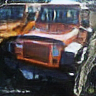

True

In [25]:
import cv2
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow

path = "/content/drive/MyDrive/cars_train/04336.jpg"

X2 = cv2.imread(path)
X1 = cv2.resize(X2,(24,24), interpolation = cv2.INTER_AREA)
X = np.reshape(X1, (1,24,24,3))
X_batch = tf.cast(X, tf.float32)

generator, discriminator = model.layers
generator.load_weights("gan_generator.h5")
Y = generator(X_batch)
cv2_imshow(X[0])
cv2_imshow( Y[0].numpy())

In [ ]:
import matplotlib.pyplot as plt
%inline
loss_disc = history_disc.history['loss']
loss_gen = history_gen.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)

plt.plot(epochs_range, loss_gen, label='Generator Loss')
plt.plot(epochs_range, loss_disc, label='Discriminator Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()